## Imports

In [1]:
%matplotlib inline
import matplotlib.pyplot as plt
import tensorflow as tf
import numpy as np
import sys
import os
from PIL import Image
from cache import cache

In [2]:
from tensorflow.python.keras import backend as K
from tensorflow.python.keras.models import Model
from tensorflow.python.keras.layers import Input, Dense, GRU, Embedding
from tensorflow.python.keras.applications import VGG16
from tensorflow.python.keras.optimizers import RMSprop
from tensorflow.python.keras.callbacks import ModelCheckpoint, TensorBoard
from tensorflow.python.keras.preprocessing.text import Tokenizer
from tensorflow.python.keras.preprocessing.sequence import pad_sequences

In [3]:
import coco

In [4]:
coco.set_data_dir("/media/ruler/data_repository/Academics/data/coco")

In [5]:
coco.maybe_download_and_extract()

Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.
Data has apparently already been downloaded and unpacked.


# we only need filenames and captions for the images

In [6]:
_, filenames_train, captions_train = coco.load_records(train=True)

- Data loaded from cache-file: /media/ruler/data_repository/Academics/data/coco/records_train.pkl


In [7]:
num_images_train = len(filenames_train)
num_images_train

118287

In [8]:
_, filenames_val, captions_val = coco.load_records(train=False)

- Data loaded from cache-file: /media/ruler/data_repository/Academics/data/coco/records_val.pkl


In [9]:
def load_image(path, size=None):
    """
    Load the image from the given file-path and resize it
    to the given size if not none(i.e. the image exists).
    """

    # Load the image using PIL.
    img = Image.open(path)

    # Resize image if desired.
    if not size is None:
        # resize method does resizing via convolutions, earlier name of the constant was ANTIALIAS
        img = img.resize(size=size, resample=Image.LANCZOS)

    # Convert image to numpy array.
    img = np.array(img)

    # Scale image-pixels so they fall between 0.0 and 1.0
    img = img / 255.0

    # Convert 2-dim gray-scale array to 3-dim RGB array.
    if (len(img.shape) == 2):
        # leave all the rows and cols as they are and add a new 3rd axis after the second axis
        img = np.repeat(img[:, :, np.newaxis], 3, axis=2)

    return img

In [10]:
def show_image(idx, train):
    """
    Load and plot an image from the training- or validation-set
    with the given index.
    """

    if train:
        # Use an image from the training-set.
        dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use an image from the validation-set.
        dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    path = os.path.join(dir, filename)

    # Print the captions for this image.
    for caption in captions:
        print(caption)
    
    img = load_image(path)
    plt.imshow(img)
    plt.show()

A motorcycle parked in a parking space next to another motorcycle.
An old motorcycle parked beside other motorcycles with a brown leather seat.
Motorcycle parked in the parking lot of asphalt.
A close up view of a motorized bicycle, sitting in a rack. 
The back tire of an old style motorcycle is resting in a metal stand. 


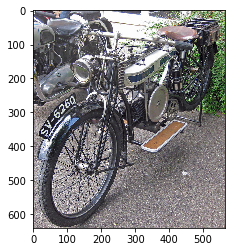

In [11]:
show_image(idx=11, train=True)

# Downloading the pre-trained VGG-16 image model for the encoder side : 

In [12]:
image_model = VGG16(include_top=True, weights='imagenet')

198959104/553467096 [=========>....................] - ETA: 20:20

KeyboardInterrupt: 

In [20]:
image_model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 224, 224, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 224, 224, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 224, 224, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 112, 112, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 112, 112, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 112, 112, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 56, 56, 128)       0         
__________

# Taking the last layer of the VGG16 model as the transfer layer

In [21]:
transfer_layer = image_model.get_layer('fc2')

In [22]:
image_model_transfer = Model(inputs=image_model.input,
                             outputs=transfer_layer.output)

In [23]:
img_size = K.int_shape(image_model.input)[1:3]
img_size

(224, 224)

## Each image is now a 4096 element vector containing the detailed feature information of the image

In [24]:
transfer_values_size = K.int_shape(transfer_layer.output)[1]
transfer_values_size

4096

In [25]:
def print_progress(count, max_count):
    # Percentage completion.
    pct_complete = count / max_count

    # Status-message. Note the \r which means the line should
    # overwrite itself.
    msg = "\r- Progress: {0:.1%}".format(pct_complete)

    # Print it.
    sys.stdout.write(msg)
    sys.stdout.flush()

In [26]:
def process_images(data_dir, filenames, batch_size=32):
    """
    Process all the given files in the given data_dir using the
    pre-trained image-model and return their transfer-values.
    
    Note that we process the images in batches to save
    memory and improve efficiency on the GPU.
    """
    
    # Number of images to process.
    num_images = len(filenames)

    # Pre-allocate input-batch-array for images.
    # img_size is a global variable declared on the input specifications of the pre-trained model
    shape = (batch_size,) + img_size + (3,)
    print(shape)
    
    # Note that we use 16-bit floating-points to save memory.
    image_batch = np.zeros(shape=shape, dtype=np.float16)

    # Pre-allocate output-array for transfer-values.
    shape = (num_images, transfer_values_size)
    print(shape)
    
    transfer_values = np.zeros(shape=shape, dtype=np.float16)

    start_index = 0

    # Process batches of image-files.
    while start_index < num_images:
        # Print the percentage-progress.
        print_progress(count=start_index, max_count=num_images)

        # marking the end_index for this batch
        end_index = start_index + batch_size

        # Ensure end-index is within bounds.
        if end_index > num_images:
            end_index = num_images

        # The last batch may have a different batch-size, 
        # so this value will be same for all other batches except the last one.
        current_batch_size = end_index - start_index

        ##################################################################################
        # Load all the images in the batch.
        for i, filename in enumerate(filenames[start_index:end_index]):
            # Path for the image-file.
            path = os.path.join(data_dir, filename)

            # Load and resize the image.
            # This returns the image as a numpy-array.
            img = load_image(path, size=img_size)

            # Save the image for later use.
            image_batch[i] = img
        ##################################################################################
        
        # Use the pre-trained image-model to process the image(basically do only forward propagation).
        # Note that the last batch may have a different size,
        # so we only use the relevant images.
        transfer_values_batch = \
            image_model_transfer.predict(image_batch[0:current_batch_size])

        # Save the transfer-values in the pre-allocated array.
        transfer_values[start_index:end_index] = \
            transfer_values_batch[0:current_batch_size]

        # Increase the index for the next loop-iteration.
        start_index = end_index

    # Print newline.
    print()

    return transfer_values

In [27]:
def process_images_train():
    print("Processing {0} images in training-set ...".format(len(filenames_train)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir,
                              "transfer_values_train.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.train_dir, # given to the process_image function as args
                            filenames=filenames_train) # given to the process_image function as args

    return transfer_values

In [28]:
def process_images_val():
    print("Processing {0} images in validation-set ...".format(len(filenames_val)))

    # Path for the cache-file.
    cache_path = os.path.join(coco.data_dir, "transfer_values_val.pkl")

    # If the cache-file already exists then reload it,
    # otherwise process all images and save their transfer-values
    # to the cache-file so it can be reloaded quickly.
    transfer_values = cache(cache_path=cache_path,
                            fn=process_images,
                            data_dir=coco.val_dir,
                            filenames=filenames_val)

    return transfer_values

In [29]:
%%time
transfer_values_train = process_images_train()
print("dtype:", transfer_values_train.dtype)
print("shape:", transfer_values_train.shape)

Processing 118287 images in training-set ...
- Data loaded from cache-file: /media/ruler/data_repository/Academics/data/coco/transfer_values_train.pkl
dtype: float16
shape: (118287, 4096)
CPU times: user 35 ms, sys: 1.65 s, total: 1.69 s
Wall time: 8.24 s


In [30]:
%%time
transfer_values_val = process_images_val()
print("dtype:", transfer_values_val.dtype)
print("shape:", transfer_values_val.shape)

Processing 5000 images in validation-set ...
- Data loaded from cache-file: /media/ruler/data_repository/Academics/data/coco/transfer_values_val.pkl
dtype: float16
shape: (5000, 4096)
CPU times: user 29.3 ms, sys: 81.1 ms, total: 110 ms
Wall time: 543 ms


In [31]:
mark_start = 'ssss '
mark_end = ' eeee'

In [32]:
def mark_captions(captions_listlist):
    captions_marked = [[mark_start + caption + mark_end
                        for caption in captions_list]
                        for captions_list in captions_listlist]
    
    return captions_marked

In [33]:
captions_train_marked = mark_captions(captions_train)
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

In [34]:
captions_train[0]

['Closeup of bins of food that include broccoli and bread.',
 'A meal is presented in brightly colored plastic trays.',
 'there are containers filled with different kinds of foods',
 'Colorful dishes holding meat, vegetables, fruit, and bread.',
 'A bunch of trays that have different food.']

### Tokenizer in keras needs a flat list - list of list into a list of captions

In [35]:
def flatten(captions_listlist):
    captions_list = [caption
                     for captions_list in captions_listlist
                     for caption in captions_list]
    
    return captions_list

In [36]:
captions_train_flat = flatten(captions_train_marked)
captions_train_flat[0]

'ssss Closeup of bins of food that include broccoli and bread. eeee'

In [37]:
num_words = 10000

In [38]:
class TokenizerWrap(Tokenizer):
    """Wrap the Tokenizer-class from Keras with more functionality."""
    
    def __init__(self, texts, num_words=None):
        """
        :param texts: List of strings with the data-set.
        :param num_words: Max number of words to use.
        """

        # initializing the internal Tokenizer class of Keras
        Tokenizer.__init__(self, num_words=num_words)

        # Create the vocabulary from the texts.
        self.fit_on_texts(texts)

        # Create inverse lookup from integer-tokens to words (not provided by Keras internally)
        self.index_to_word = dict(zip(self.word_index.values(),
                                      self.word_index.keys()))

    def token_to_word(self, token):
        """Lookup a single word from an integer-token."""

        word = " " if token == 0 else self.index_to_word[token]
        return word 

    def tokens_to_string(self, tokens):
        """Convert a list of integer-tokens to a string."""

        # Create a list of the individual words.
        words = [self.index_to_word[token]
                 for token in tokens
                 if token != 0]
        
        # Concatenate the words to a single string
        # with space between all the words.
        text = " ".join(words)

        return text
    
    def captions_to_tokens(self, captions_listlist):
        """
        Convert a list-of-list with text-captions to
        a list-of-list of integer-tokens at once.
        """
        
        # Note that text_to_sequences() takes a list of texts.
        tokens = [self.texts_to_sequences(captions_list)
                  for captions_list in captions_listlist]
        
        return tokens

In [39]:
%%time
tokenizer = TokenizerWrap(texts=captions_train_flat,
                          num_words=num_words)

CPU times: user 7.49 s, sys: 0 ns, total: 7.49 s
Wall time: 7.49 s


In [40]:
token_start = tokenizer.word_index[mark_start.strip()]
token_start

2

In [41]:
token_end = tokenizer.word_index[mark_end.strip()]
token_end

3

In [42]:
%%time
tokens_train = tokenizer.captions_to_tokens(captions_train_marked)

CPU times: user 6.88 s, sys: 0 ns, total: 6.88 s
Wall time: 6.88 s


In [43]:
tokens_train[0]

[[2, 841, 5, 2864, 5, 61, 26, 1984, 238, 9, 433, 3],
 [2, 1, 429, 10, 3310, 7, 1025, 390, 501, 1110, 3],
 [2, 63, 19, 993, 143, 8, 190, 958, 5, 743, 3],
 [2, 299, 725, 25, 343, 208, 264, 9, 433, 3],
 [2, 1, 170, 5, 1110, 26, 446, 190, 61, 3]]

In [44]:
captions_train_marked[0]

['ssss Closeup of bins of food that include broccoli and bread. eeee',
 'ssss A meal is presented in brightly colored plastic trays. eeee',
 'ssss there are containers filled with different kinds of foods eeee',
 'ssss Colorful dishes holding meat, vegetables, fruit, and bread. eeee',
 'ssss A bunch of trays that have different food. eeee']

In [45]:
def get_random_caption_tokens(idx):
    """
    Given a list of indices for images in the training-set,
    select a token-sequence for a random caption,
    and return a list of all these token-sequences.
    """
    
    # Initialize an empty list for the results.
    result = []

    # For each of the indices.
    for i in idx:
        # The index i points to an image in the training-set.
        # Each image in the training-set has at least 5 captions
        # which have been converted to tokens in tokens_train.
        # We want to select one of these token-sequences at random.

        # Get a random index for a token-sequence.
        j = np.random.choice(len(tokens_train[i]))
#         print(j)
        # Get the j'th token-sequence for image i.
        tokens = tokens_train[i][j]

        # Add this token-sequence to the list of results.
        result.append(tokens)

    return result

In [46]:
def batch_generator(batch_size):
    """
    Generator function for creating random batches of training-data.
    
    Note that it selects the data completely randomly for each
    batch, corresponding to sampling of the training-set with
    replacement. This means it is possible to sample the same
    data multiple times within a single epoch - and it is also
    possible that some data is not sampled at all within an epoch.
    However, all the data should be unique within a single batch.
    """

    # Infinite loop.
    while True:
        # Get a list(len = batch size) of random indices for images in the training-set.
        idx = np.random.randint(num_images_train,
                                size=batch_size)
        
        # Get the pre-computed transfer-values for those images.
        # These are the outputs of the pre-trained image-model.
        transfer_values = transfer_values_train[idx]

        # For each of the randomly chosen images there are
        # at least 5 captions describing the contents of the image.
        # Select one of those captions at random and get the
        # associated sequence of integer-tokens.
        tokens = get_random_caption_tokens(idx)

        # Count the number of tokens in all these token-sequences.
        num_tokens = [len(t) for t in tokens]
        
        # Max number of tokens in a caption among all the captions
        max_tokens = np.max(num_tokens)
        
        # Pad all the other token-sequences with zeros
        # so they all have the same length and can be
        # input to the neural network as a numpy array.
        tokens_padded = pad_sequences(tokens,
                                      maxlen=max_tokens,
                                      padding='post',
                                      truncating='post')
        
        # Further prepare the token-sequences at the decoder part.
        # The decoder-part of the neural network
        # will try to map the token-sequences to
        # themselves shifted one time-step.
        decoder_input_data = tokens_padded[:, 0:-1] # 0th column to the last column
        decoder_output_data = tokens_padded[:, 1:] # 1st column to the last column (so shifted one unit back)

        # Dict for the input-data. Because we have
        # several inputs, we use a named dict to
        # ensure that the data is assigned correctly.
        x_data = \
        {
            'decoder_input': decoder_input_data,
            'transfer_values_input': transfer_values
        }

        # Dict for the output-data.
        y_data = \
        {
            'decoder_output': decoder_output_data
        }
        
        yield (x_data, y_data)

In [47]:
batch_size = 256 # batch for 1 epoch training of the neural network

In [48]:
generator = batch_generator(batch_size=batch_size)

In [49]:
# basically generator here is an iterator that by next(), we are iterating over batches one after another 
batch = next(generator) 
batch_x = batch[0]
batch_y = batch[1]

In [50]:
# this is basically containing all the semantic information about the image in an array of 4096 elements 
batch_x['transfer_values_input'][0] 

array([0.   , 0.   , 1.367, ..., 0.   , 0.   , 0.929], dtype=float16)

In [51]:
batch_x['decoder_input'][0]

array([  2,   1,  11, 450,  34,   1,  37,  75, 252,   1, 726,   3,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [52]:
batch_y['decoder_output'][0]

array([  1,  11, 450,  34,   1,  37,  75, 252,   1, 726,   3,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   0,   0,   0], dtype=int32)

In [53]:
num_captions_train = [len(captions) for captions in captions_train]

This is the total number of captions in the training-set.

In [54]:
total_num_captions_train = np.sum(num_captions_train)

This is the approximate number of batches required per epoch, if we want to process each caption and image pair once per epoch.

In [55]:
steps_per_epoch = int(total_num_captions_train / batch_size)
steps_per_epoch

2311

In [56]:
state_size = 512 # for the internal state of the LSTM

In [57]:
embedding_size = 128

### Decoder construction : 

In [58]:
transfer_values_input = Input(shape=(transfer_values_size,),
                              name='transfer_values_input')

Transfer values are needed to initialize the internal states of the GRU units. Transfer values are vectors of length 4096 but they need to be mapped to the internal state of the GRU units which are of 512 units only. So, a fully connected layer maps these 4096 elements to 512 elements. Tanh activation makes the values between -1 and +1.

In [59]:
decoder_transfer_map = Dense(state_size,
                             activation='tanh',
                             name='decoder_transfer_map')

This is the input for token-sequences to the decoder. Using `None` in the shape means that the token-sequences can have arbitrary lengths.

In [60]:
decoder_input = Input(shape=(None, ), name='decoder_input')

This is the embedding-layer which converts sequences of integer-tokens to sequences of vectors.

In [61]:
decoder_embedding = Embedding(input_dim=num_words,
                              output_dim=embedding_size,
                              name='decoder_embedding')

This creates the 3 GRU layers of the decoder. Note that they all return sequences because we ultimately want to output a sequence of integer-tokens that can be converted into a text-sequence.

In [62]:
decoder_gru1 = GRU(state_size, name='decoder_gru1',
                   return_sequences=True)
decoder_gru2 = GRU(state_size, name='decoder_gru2',
                   return_sequences=True)
decoder_gru3 = GRU(state_size, name='decoder_gru3',
                   return_sequences=True)

Another dense layer to convert vectors of 512 elements into one-hot vectors of 10000 elements to get the words out of those vectors. 

Activation function is set to linear instead of softmax, as normally done for one-hot encoded outputs because the loss-function in Keras has a problem described later below ! 

In [63]:
decoder_dense = Dense(num_words,
                      activation='linear',
                      name='decoder_output')

In [64]:
def connect_decoder(transfer_values):
    # Map the transfer-values so the dimensionality matches
    # the internal state of the GRU layers. This means
    # we can use the mapped transfer-values as the initial state
    # of the GRU layers.
    initial_state = decoder_transfer_map(transfer_values)

    # Start the decoder-network with its input-layer.
    net = decoder_input
    
    # Connect the embedding-layer.
    net = decoder_embedding(net)
    
    # Connect all the GRU layers.
    net = decoder_gru1(net, initial_state=initial_state)
    net = decoder_gru2(net, initial_state=initial_state)
    net = decoder_gru3(net, initial_state=initial_state)

    # Connect the final dense layer that converts to
    # one-hot encoded arrays.
    decoder_output = decoder_dense(net)
    
    return decoder_output

In [65]:
decoder_output = connect_decoder(transfer_values=transfer_values_input)

decoder_model = Model(inputs=[transfer_values_input, decoder_input],
                      outputs=[decoder_output])

We have to define our own custom loss-function because the sparse_categorical_crossentropy function in keras outputs a 3-rank tensor with shape = [batch_size, sequence_length, num_words] but our true label is a 2-rank tensor with shape = [batch_size, sequence_length], hence we use the sparse_softmax_cross_entropy_with_logits function of tensorflow.

The loss-function calculates the softmax internally to improve numerical stability - this is why we used a linear activation function in the last dense-layer of the decoder-network above.

We calculate the loss-function across the entire batch and across the entire sequences, we manually calculate the loss average.

In [66]:
def sparse_cross_entropy(y_true, y_pred):
    """
    Calculate the cross-entropy loss between y_true and y_pred.
    
    y_true is a 2-rank tensor with the desired output.
    The shape is [batch_size, sequence_length] and it
    contains sequences of integer-tokens.

    y_pred is the decoder's output which is a 3-rank tensor
    with shape [batch_size, sequence_length, num_words]
    so that for each sequence in the batch there is a one-hot
    encoded array of length num_words.
    """

    # Calculate the loss. This outputs a
    # 2-rank tensor of shape [batch_size, sequence_length]
    loss = tf.nn.sparse_softmax_cross_entropy_with_logits(labels=y_true,
                                                          logits=y_pred)

    # Keras may reduce this across the first axis (the batch)
    # but the semantics are unclear, so to be sure we use
    # the loss across the entire 2-rank tensor, we reduce it
    # to a single scalar with the mean function.
    loss_mean = tf.reduce_mean(loss)

    return loss_mean

In [67]:
optimizer = RMSprop(lr=1e-3)

In [68]:
decoder_target = tf.placeholder(dtype='int32', shape=(None, None))

In [69]:
decoder_model.compile(optimizer=optimizer,
                      loss=sparse_cross_entropy,
                      target_tensors=[decoder_target])

In [70]:
path_checkpoint = 'show_and_tell_checkpoint.keras'
callback_checkpoint = ModelCheckpoint(filepath=path_checkpoint,
                                      verbose=1,
                                      save_weights_only=True)

This is the callback for writing the TensorBoard log during training.

In [71]:
callback_tensorboard = TensorBoard(log_dir='./22_logs/',
                                   histogram_freq=0,
                                   write_graph=False)

In [72]:
callbacks = [callback_checkpoint, callback_tensorboard]

In [75]:
try:
    decoder_model.load_weights(path_checkpoint)
except Exception as error:
    print("Error trying to load checkpoint.")
    print(error)

In [76]:
# %%time
# decoder_model.fit_generator(generator=generator,
#                             steps_per_epoch=steps_per_epoch,
#                             epochs=1,
#                             callbacks=callbacks)

In [77]:
def generate_caption(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tlokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1

    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]

    # Plot the image.
    plt.imshow(image)
    plt.show()
    
    # Print the predicted caption.
    print("Predicted caption:")
    output_text = output_text[:-4]
    print(output_text)
    print()

## Mixed image data from the internet 

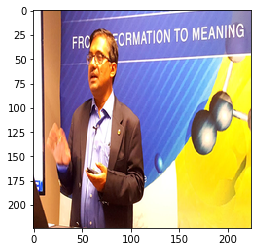

Predicted caption:
 a man in a suit and tie is smiling 



In [78]:
generate_caption("images/pushpak_sir.jpg")

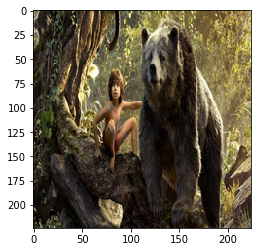

Predicted caption:
 a black bear walking through a forest with a dog 



In [214]:
generate_caption("images/jungle-bookjpg.jpeg")

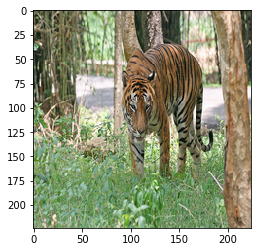

Predicted caption:
 a black bear walking through a forest with trees 



In [79]:
generate_caption("images/bengal-tiger.jpg")

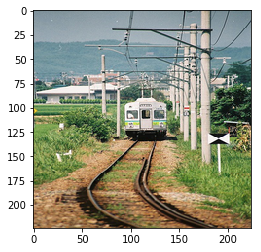

Predicted caption:
 a train is traveling down the tracks in the middle of the day 



In [216]:
generate_caption("images/000002.jpg")

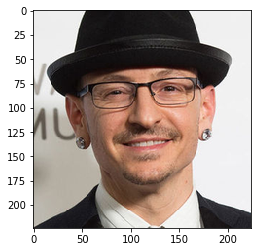

Predicted caption:
 a man in a suit and tie posing for a picture 



In [113]:
generate_caption("images/chester.jpeg")

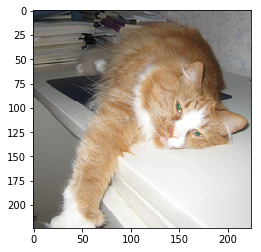

Predicted caption:
 a cat sitting on a table next to a pair of sneakers 



In [217]:
generate_caption("images/image02.jpg")

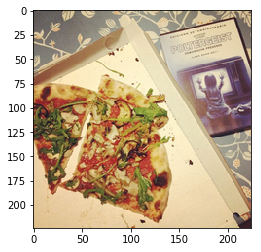

Predicted caption:
 a plate of food on a table with a fork 



In [218]:
generate_caption("images/image03.jpg")

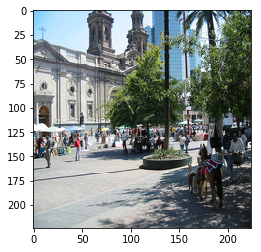

Predicted caption:
 a group of people walking down a street 



In [219]:
generate_caption("images/image01.jpg")

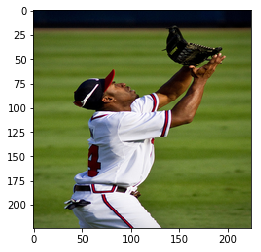

Predicted caption:
 a baseball player is getting ready to hit a ball 



In [74]:
generate_caption("images/image04.jpg")

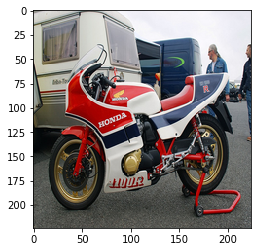

Predicted caption:
 a person on a motorcycle on a city street 



In [75]:
generate_caption("images/image05.jpg")

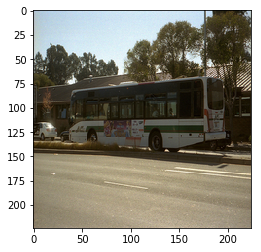

Predicted caption:
 a bus driving down a street next to a forest 



In [226]:
generate_caption("images/image06.jpg")

## Evaluation on COCO dataset itself to test overfitting and performance on training set.

In [80]:
def generate_caption_coco(idx, train=False):
    """
    Generate a caption for an image in the COCO data-set.
    Use the image with the given index in either the
    training-set (train=True) or validation-set (train=False).
    """
    
    if train:
        # Use image and captions from the training-set.
        data_dir = coco.train_dir
        filename = filenames_train[idx]
        captions = captions_train[idx]
    else:
        # Use image and captions from the validation-set.
        data_dir = coco.val_dir
        filename = filenames_val[idx]
        captions = captions_val[idx]

    # Path for the image-file.
    path = os.path.join(data_dir, filename)

    # Use the model to generate a caption of the image.
    generate_caption(image_path=path)

    # Print the true captions from the data-set.
    print("True captions:")
    for caption in captions:
        print(caption)

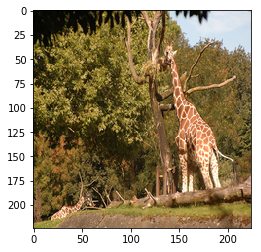

Predicted caption:
 a giraffe standing in a field of grass 

True captions:
A giraffe eating food from the top of the tree.
A giraffe standing up nearby a tree 
A giraffe mother with its baby in the forest.
Two giraffes standing in a tree filled area.
A giraffe standing next to a forest filled with trees.


In [81]:
generate_caption_coco(idx=1, train=True)

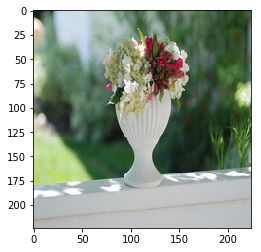

Predicted caption:
 a bird sitting on top of a tree branch 

True captions:
A flower vase is sitting on a porch stand.
White vase with different colored flowers sitting inside of it. 
a white vase with many flowers on a stage
A white vase filled with different colored flowers.
A vase with red and white flowers outside on a sunny day.


In [82]:
generate_caption_coco(idx=2, train=True)

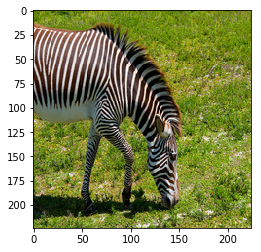

Predicted caption:
 a zebra standing on a lush green field 

True captions:
A zebra grazing on lush green grass in a field.
Zebra reaching its head down to ground where grass is. 
The zebra is eating grass in the sun.
A lone zebra grazing in some green grass.
a Zebra grazing on grass in a green open field.


In [83]:
generate_caption_coco(idx=3, train=True)

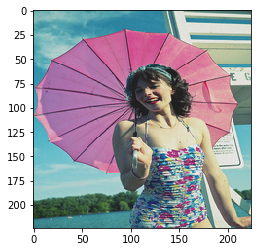

Predicted caption:
 a little girl holding a blue umbrella in a field 

True captions:
Woman in swim suit holding parasol on sunny day.
A woman posing for the camera, holding a pink, open umbrella and wearing a bright, floral, ruched bathing suit, by a life guard stand with lake, green trees, and a blue sky with a few clouds behind.
A woman in a floral swimsuit holds a pink umbrella.
A woman with an umbrella near the sea
A girl in a bathing suit with a pink umbrella.


In [84]:
generate_caption_coco(idx=4, train=True)

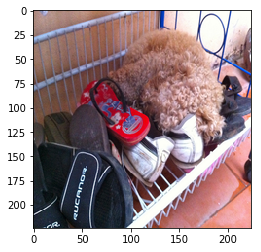

Predicted caption:
 a cat laying on top of a computer keyboard 

True captions:
This wire metal rack holds several pairs of shoes and sandals
A dog sleeping on a show rack in the shoes.
Various slides and other footwear rest in a metal basket outdoors.
A small dog is curled up on top of the shoes
a shoe rack with some shoes and a dog sleeping on them


In [85]:
generate_caption_coco(idx=5, train=True)

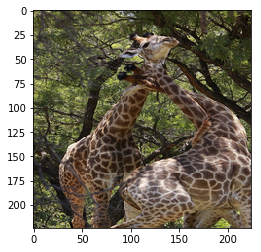

Predicted caption:
 a giraffe standing in a field next to a tree 

True captions:
A couple of giraffe snuggling each other in a forest.
A couple of giraffe standing next to some trees.
Two Zebras seem to be embracing in the wild. 
Two giraffes hang out near trees and nuzzle up to each other.
The two giraffes appear to be hugging each other.


In [86]:
generate_caption_coco(idx=10, train=True)

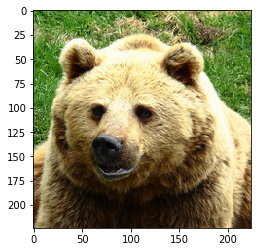

Predicted caption:
 a dog with a frisbee in its mouth 

True captions:
A big burly grizzly bear is show with grass in the background.
The large brown bear has a black nose.
Closeup of a brown bear sitting in a grassy area.
A large bear that is sitting on grass. 
A close up picture of a brown bear's face.


In [109]:
generate_caption_coco(idx=1, train=False)

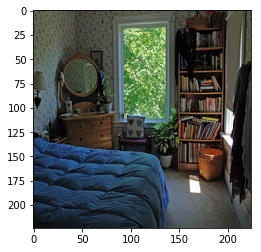

Predicted caption:
 a living room with a couch and a television 

True captions:
Bedroom scene with a bookcase, blue comforter and window.
A bedroom with a bookshelf full of books.
This room has a bed with blue sheets and a large bookcase
A bed and a mirror in a small room.
a bed room with a neatly made bed a window and a book shelf


In [110]:
generate_caption_coco(idx=2, train=False)

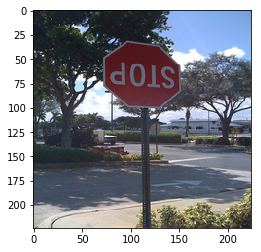

Predicted caption:
 a stop sign with a sticker on it 

True captions:
A stop sign is mounted upside-down on it's post. 
A stop sign that is hanging upside down.
An upside down stop sign by the road.
a stop sign put upside down on a metal pole 
A stop sign installed upside down on a street corner


In [89]:
generate_caption_coco(idx=3, train=False)

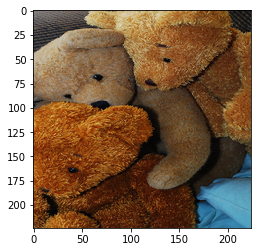

Predicted caption:
 a teddy bear is wearing a bow tie 

True captions:
Three teddy bears, each a different color, snuggling together.
Three stuffed animals are sitting on a bed. 
three teddy bears giving each other a hug
A group of three stuffed animal teddy bears.
Three stuffed bears hugging and sitting on a blue pillow


In [90]:
generate_caption_coco(idx=4, train=False)

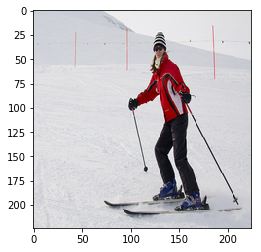

Predicted caption:
 a person on a snowboard in the snow 

True captions:
A woman posing for the camera standing on skis.
a woman standing on skiis while posing for the camera
A woman in a red jacket skiing down a slope
A young woman is skiing down the mountain slope. 
a person on skis makes her way through the snow


In [91]:
generate_caption_coco(idx=5, train=False)

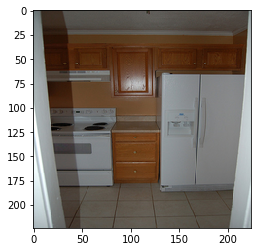

Predicted caption:
 a bathroom with a toilet sink and shower 

True captions:
A kitchen with a refrigerator, stove and oven with cabinets.
A white oven and a white refrigerator are in the kitchen.
The refrigerator is brand new and was delivered today.
Stark white appliances stand out against brown wooden cabinets.
Kitchen appliances and cabinets as seen through opening.


In [111]:
generate_caption_coco(idx=6, train=False)

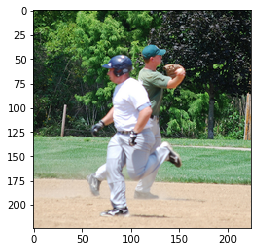

Predicted caption:
 a baseball player is swinging a bat at a ball 

True captions:
A couple of baseball player standing on a field.
Two men playing baseball in a field on a sunny day.
two baseball players are playing baseball on a field
A couple of men play baseball and the batter runs for base.
Two guys playing baseball, with trees in the back.


In [93]:
generate_caption_coco(idx=7, train=False)

In [95]:
def generate_caption_for_blue(image_path, max_tokens=30):
    """
    Generate a caption for the image in the given path.
    The caption is limited to the given number of tokens (words).
    """

    # Load and resize the image.
    image = load_image(image_path, size=img_size)
    
    # Expand the 3-dim numpy array to 4-dim
    # because the image-model expects a whole batch as input,
    # so we give it a batch with just one image.
    image_batch = np.expand_dims(image, axis=0)

    # Process the image with the pre-trained image-model
    # to get the transfer-values.
    transfer_values = image_model_transfer.predict(image_batch)

    # Pre-allocate the 2-dim array used as input to the decoder.
    # This holds just a single sequence of integer-tokens,
    # but the decoder-model expects a batch of sequences.
    shape = (1, max_tokens)
    decoder_input_data = np.zeros(shape=shape, dtype=np.int)

    # The first input-token is the special start-token for 'ssss '.
    token_int = token_start

    # Initialize an empty output-text.
    output_text = ''

    # Initialize the number of tokens we have processed.
    count_tokens = 0

    # While we haven't sampled the special end-token for ' eeee'
    # and we haven't processed the max number of tokens.
    while token_int != token_end and count_tokens < max_tokens:
        # Update the input-sequence to the decoder
        # with the last token that was sampled.
        # In the first iteration this will set the
        # first element to the start-token.
        decoder_input_data[0, count_tokens] = token_int

        # Wrap the input-data in a dict for clarity and safety,
        # so we are sure we input the data in the right order.
        x_data = \
        {
            'transfer_values_input': transfer_values,
            'decoder_input': decoder_input_data
        }

        
        
        # Input this data to the decoder and get the predicted output.
        decoder_output = decoder_model.predict(x_data)

        # Get the last predicted token as a one-hot encoded array.
        token_onehot = decoder_output[0, count_tokens, :]

        # Convert to an integer-token.
        token_int = np.argmax(token_onehot)

        # Lookup the word corresponding to this integer-token.
        sampled_word = tokenizer.token_to_word(token_int)

        # Append the word to the output-text.
        output_text += " " + sampled_word

        # Increment the token-counter.
        count_tokens += 1
    
    # This is the sequence of tokens output by the decoder.
    output_tokens = decoder_input_data[0]
#     print(output_tokens)
    output_text = output_text[:-5]
    return output_text

## BLUE Score evaluation 

In [96]:
# 4-gram cumulative BLEU

from nltk.translate.bleu_score import sentence_bleu


In [97]:
def calculateBleu1(candidate, references):
#     reference = [['this', 'is', 'small', 'test']]
#     candidate = ['this', 'is', 'a', 'test']
    return sentence_bleu(references, candidate, weights=(1,0,0,0))

In [98]:
def calculateBleu2(candidate, references):
#     reference = [['this', 'is', 'small', 'test']]
#     candidate = ['this', 'is', 'a', 'test']
    return sentence_bleu(references, candidate, weights=(0.5,0.5,0,0))

In [99]:
def calculateBleu3(candidate, references):
#     reference = [['this', 'is', 'small', 'test']]
#     candidate = ['this', 'is', 'a', 'test']
    return sentence_bleu(references, candidate, weights=(0.33,0.33,0.33,0))

In [100]:
def calculateBleu4(candidate, references):
#     reference = [['this', 'is', 'small', 'test']]
#     candidate = ['this', 'is', 'a', 'test']
    return sentence_bleu(references, candidate, weights=(0.25,0.25,0.25,0.25))

In [103]:
def blue1_score_calculation_coco():
    """
    Calculates the blue-1 score for the ms-coco validation dataset 
    containing 5000 images with 5 captions per image
    """
    
    data_dir = coco.val_dir

    blue1_dataset_sum = 0
#     for idx in range(0, len(filenames_val)):
    for idx in range(0, 100):
        filename = filenames_val[idx]
        captions = captions_val[idx]
        path = os.path.join(data_dir, filename)
        candidate_text = generate_caption_for_blue(image_path=path)
        # need to convert into the format required by the inbuilt blue score calculator function
        candidate = [word for word in candidate_text.lower().split()]
#         print(candidate)
        references = []
        for caption in captions:
            ref = [word for word in caption.lower().split()]
            references.append(ref)
#         print("========================================")
#         print(references)
#         print("========================================")

        blue1_dataset_sum = blue1_dataset_sum + calculateBleu1(candidate, references)

        
#     blue1_dataset = blue1_dataset_sum/(len(filenames_val))
    blue1_dataset = blue1_dataset_sum/100

    return blue1_dataset


In [104]:
def blue2_score_calculation_coco():
    """
    Calculates the blue-2 score for the ms-coco validation dataset 
    containing 5000 images with 5 captions per image
    """
    
    data_dir = coco.val_dir

    blue2_dataset_sum = 0
#     for idx in range(0, len(filenames_val)):
    for idx in range(0, 100):
        filename = filenames_val[idx]
        captions = captions_val[idx]
        path = os.path.join(data_dir, filename)
        candidate_text = generate_caption_for_blue(image_path=path)
        # need to convert into the format required by the inbuilt blue score calculator function
        candidate = [word for word in candidate_text.lower().split()]
#         print(candidate)
        references = []
        for caption in captions:
            ref = [word for word in caption.lower().split()]
            references.append(ref)
#         print("========================================")
#         print(references)
#         print("========================================")
        blue2_dataset_sum = blue2_dataset_sum + calculateBleu2(candidate, references)

        
#     blue2_dataset = blue2_dataset_sum/(len(filenames_val))
    blue2_dataset = blue2_dataset_sum/100

    return blue2_dataset


In [105]:
def blue3_score_calculation_coco():
    """
    Calculates the blue-3 score for the ms-coco validation dataset 
    containing 5000 images with 5 captions per image
    """
    
    data_dir = coco.val_dir

    blue3_dataset_sum = 0
#     for idx in range(0, len(filenames_val)):
    for idx in range(0,100):
        filename = filenames_val[idx]
        captions = captions_val[idx]
        path = os.path.join(data_dir, filename)
        candidate_text = generate_caption_for_blue(image_path=path)
        # need to convert into the format required by the inbuilt blue score calculator function
        candidate = [word for word in candidate_text.lower().split()]
#         print(candidate)
        references = []
        for caption in captions:
            ref = [word for word in caption.lower().split()]
            references.append(ref)
#         print("========================================")
#         print(references)
#         print("========================================")
        blue3_dataset_sum = blue3_dataset_sum + calculateBleu3(candidate, references)

    
#     blue3_dataset = blue3_dataset_sum/(len(filenames_val))
    blue3_dataset = blue3_dataset_sum/100

    return blue3_dataset


In [106]:
def blue4_score_calculation_coco():
    """
    Calculates the blue-4 score for the ms-coco validation dataset 
    containing 5000 images with 5 captions per image
    """
    
    data_dir = coco.val_dir

    blue4_dataset_sum = 0
#     for idx in range(0, len(filenames_val)):
    for idx in range(0, 100):
        filename = filenames_val[idx]
        captions = captions_val[idx]
        path = os.path.join(data_dir, filename)
        candidate_text = generate_caption_for_blue(image_path=path)
        # need to convert into the format required by the inbuilt blue score calculator function
        candidate = [word for word in candidate_text.lower().split()]
#         print(candidate)
        references = []
        for caption in captions:
            ref = [word for word in caption.lower().split()]
            references.append(ref)
#         print("========================================")
#         print(references)
#         print("========================================")
        blue4_dataset_sum = blue4_dataset_sum + calculateBleu4(candidate, references)

        
#     blue4_dataset = blue4_dataset_sum/(len(filenames_val))
    blue4_dataset = blue4_dataset_sum/100
    return blue4_dataset


In [251]:
blue1_dataset = blue1_score_calculation_coco()
blue1_dataset

In [252]:
print(blue1_dataset)

0.5771095444609327


In [253]:
blue2_dataset = blue2_score_calculation_coco()
blue2_dataset

/home/ruler/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ruler/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ruler/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lowe

0.36131510906566255

In [107]:
blue3_dataset = blue3_score_calculation_coco()
blue3_dataset

/home/ruler/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 3-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ruler/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 4-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lower order it contains.
Consider using lower n-gram order or use SmoothingFunction()
  warnings.warn(_msg)
/home/ruler/anaconda3/envs/tensorflow_gpuenv/lib/python3.6/site-packages/nltk/translate/bleu_score.py:523: UserWarning: 
The hypothesis contains 0 counts of 2-gram overlaps.
Therefore the BLEU score evaluates to 0, independently of
how many N-gram overlaps of lowe

0.18163629682949536

In [108]:
blue4_dataset = blue4_score_calculation_coco()
blue4_dataset

0.08023370912397883